In [291]:
from k_means_constrained import KMeansConstrained
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from shapely.geometry import Polygon, LineString, Point
from shapely.ops import split,nearest_points
from newton_multidimention import Optimize_Drone_Position_Euclidean

## Creating the delivery Locations

In [292]:
def create_locations(x, y, n):
    loc = []

    for _ in range(n):
        loc_x = random.randint(int(x[0]), int(y[0])) + random.randint(int((x[0] - int(x[0]))*10000), int((y[0] - int(y[0]))*10000)) / 10000
        loc_y = random.randint(int(x[1]), int(y[1])) + random.randint(int((x[1] - int(x[1]))*10000), int((y[1] - int(y[1]))*10000)) / 10000
        loc.append([loc_x,loc_y])
        
    return loc

## Verify delivary locations

In [293]:
def create_polygon(points):
    coords = []

    for pt in points:
        coords.append(pt)

    obs_polygon = Polygon(coords)
    return obs_polygon

In [294]:
def verify_locations(delivery_loc, obstacles):
    obstacle_polygon = []
    answer = []
    for obs_id, obs in obstacles.items():
        obstacle_polygon.append(create_polygon(obs))
    
    for loc in delivery_loc:
        flag = True
        for obs in obstacle_polygon:
            if Point([loc[0],loc[1]]).intersects(obs):
                flag = False
                break
        if flag:
            answer.append(loc)

    return answer

## Visualizing the data

In [295]:
def initial_plot(delivery_loc, obstacles):
    loc = np.array(delivery_loc)
    plt.scatter(loc[:,0], loc[:,1])
    for obstacle_id, points in obstacles.items():
        x = [i for i,j in points]
        y = [j for i,j in points]

        plt.fill(x,y,color="red", alpha = 0.7)
    plt.title("Delivery Locations")
    plt.show()

In [296]:
def clusters_plot(clusters, centroids, obstacles):
    for i in clusters:
        points = np.array(clusters[i])
        plt.scatter(points[:,0], points[:,1])
        #try
        center = np.mean(points, axis=0)
        radius = max(np.linalg.norm(point - center) for point in points)

        # Plot the circle
        circle = plt.Circle(center, radius, color='lightblue', fill=True, alpha=0.5)
        plt.gca().add_artist(circle)
        #try
    plt.scatter(centroids[:,0], centroids[:,1], marker='^', c="black")
    for obstacle_id, points in obstacles.items():
        x = [i for i,j in points]
        y = [j for i,j in points]
        
        plt.fill(x,y,color="red", alpha = 0.7)
    plt.title("After Clustering")
    plt.show()

In [297]:
def dp_plot(clusters, centroids, dp, obstacles):
    for i in clusters:
        points = np.array(clusters[i])
        plt.scatter(points[:,0], points[:,1])
        #try
        center = np.mean(points, axis=0)
        radius = max(np.linalg.norm(point - center) for point in points)

        # Plot the circle
        circle = plt.Circle(center, radius, color='lightblue', fill=True, alpha=0.5)
        plt.gca().add_artist(circle)
        #try
    plt.scatter(centroids[:,0], centroids[:,1], marker='^', c="black")
    plt.scatter(dp[0], dp[1], marker='+',s=200, c="red")
    for obstacle_id, points in obstacles.items():
        x = [i for i,j in points]
        y = [j for i,j in points]

        plt.fill(x,y,color="red", alpha = 0.7)
    plt.title("After DP Creation")
    plt.show()

In [298]:
def final_plot(delivery_loc,clusters, dp, obstacles, title=None):
    colors = ['blue', 'green', 'orange', 'purple', 'brown']

    deliveries = np.array(delivery_loc)
    plt.scatter(deliveries[:,0], deliveries[:,1])

    for i in clusters:
        pts = np.array(clusters[i])
        # plt.scatter(pts[:,0], pts[:,1])
        #try
        points = pts[1:-1,:]
        center = np.mean(points, axis=0)
        radius = max(np.linalg.norm(point - center) for point in points)

        # Plot the circle
        circle = plt.Circle(center, radius, color='lightblue', fill=True, alpha=0.5)
        plt.gca().add_artist(circle)
        #try

        for j in range(len(pts)-1):
            pt_1 = pts[j]
            pt_2 = pts[j+1]

            plt.plot([pt_1[0], pt_2[0]], [pt_1[1], pt_2[1]], c=colors[i % len(colors)])

    plt.scatter(dp[0], dp[1], c="red", marker='X',s=200)
    for obstacle_id, points in obstacles.items():
        x = [i for i,j in points]
        y = [j for i,j in points]

        plt.fill(x,y,color="red", alpha = 0.7)
    if title != None:
        plt.title(title)
    else:
        plt.title("Final Result")
    # plt.show()

## KMeans Clustering

In [299]:
def KMeans(delivery_loc, n, k):
    n_cluster = n//k if n%k == 0 else n//k + 1

    model = KMeansConstrained(n_clusters=n_cluster, size_min=1, size_max=k)
    model.fit_predict(np.array(delivery_loc))

    labels = model.labels_
    clusters = {label:[] for label in range(n_cluster)}

    for i in range(len(delivery_loc)):
        clusters[labels[i]].append(delivery_loc[i])

    return model.cluster_centers_, clusters

## Calculate DP

In [300]:
def calculate_dp(centroids):
    x = [i for i,j in centroids]
    y = [j for i,j in centroids]

    loc_x = np.mean(x)
    loc_y = np.mean(y)

    return [loc_x, loc_y]

## Traveling Salesman Problem

In [301]:
def calculate_distance(point1, point2):
    point1 = np.array(point1)
    point2 = np.array(point2)
    return np.sqrt(np.sum((point1 - point2)**2))

In [302]:
def total_distance(clusters):
    total = 0
    for i in clusters:
        pts = clusters[i]
        for j in range(len(pts)-1):
            total += calculate_distance(pts[j], pts[j+1])
    
    return total

In [303]:
from shapely.ops import split

In [304]:
def line_intersect(line, obstacle):
    parts = split(obstacle, line)

    count = len([geoms for geoms in parts.geoms])

    return count != 1

In [305]:
def is_obstacle_free(line, obstacles):
    for obs in obstacles:
        if line_intersect(line,obs):
            return False
    return True

In [306]:
import math

def find_inter_point(point_a, point_b, obstacles):
    route_line = LineString([point_a, point_b])
    obstacle_polygons = obstacles
    target_obs = None

    # Find all intersections with obstacles (including edges)
    intersections = []
    for obstacle in obstacle_polygons:
        for i in range(len(obstacle.exterior.coords) - 1):
            start, end = obstacle.exterior.coords[i], obstacle.exterior.coords[i + 1]
            line = LineString([start, end])
            if route_line.intersects(line):
                intersections.append(route_line.intersection(line))
            if target_obs == None and len(intersections)>0:
                target_obs = obstacle

    # If no intersections found, return None
    if not intersections:
        return None

    # Choose the intersection with the smallest sum of distances to A and B
    inter_x = sum(inter.x for inter in intersections)/len(intersections)
    inter_y = sum(inter.y for inter in intersections)/len(intersections)
    nearest_inter = Point(inter_x, inter_y)

    interval = 0.001
    increment = 0.001
    limit = 1.0

    while interval < limit:
        # Check if there's a clear path along either side of the obstacle
        left_side = LineString([point_a, Point(nearest_inter.x - interval, nearest_inter.y)])
        right_side = LineString([point_a, Point(nearest_inter.x + interval, nearest_inter.y)])
        up_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y + interval)])
        down_side = LineString([point_a, Point(nearest_inter.x , nearest_inter.y - interval)])

        # check if left_side is obstacle free
        if is_obstacle_free(left_side, obstacle_polygons):
            left_to_B = LineString([[nearest_inter.x - interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_1 = True
            for obs in obstacle_polygons:
                if(left_to_B.intersects(obs)):
                    flag_1 = False
                    break
            if flag_1:
                return [nearest_inter.x - interval, nearest_inter.y]
        # check if right_side is obstacle free
        if is_obstacle_free(right_side, obstacle_polygons):
            right_to_B = LineString([[nearest_inter.x + interval, nearest_inter.y],[point_b[0],point_b[1]]])
            flag_2 = True
            for obs in obstacle_polygons:
                if(right_to_B.intersects(obs)):
                    flag_2 = False
                    break
            if flag_2:
                return [nearest_inter.x + interval, nearest_inter.y]
        # check if up_side is obstacle free
        if is_obstacle_free(up_side, obstacle_polygons):
            up_to_B = LineString([[nearest_inter.x, nearest_inter.y + interval],[point_b[0],point_b[1]]])
            flag_3 = True
            for obs in obstacle_polygons:
                if(up_to_B.intersects(obs)):
                    flag_3 = False
                    break
            if flag_3:
                return [nearest_inter.x, nearest_inter.y + interval]
        # check if down_side is obstacle free
        if is_obstacle_free(down_side, obstacle_polygons):
            down_to_B = LineString([[nearest_inter.x, nearest_inter.y - interval],[point_b[0],point_b[1]]])
            flag_4 = True
            for obs in obstacle_polygons:
                if(down_to_B.intersects(obs)):
                    flag_4 = False
                    break
            if flag_4:
                return [nearest_inter.x, nearest_inter.y - interval]
        interval += increment

    return None

<font color="red">Try</font>

In [307]:
from shapely.affinity import translate

In [308]:
def scale_polygon(polygon, scale_factor = 0.99):
    centroid = polygon.centroid

    # Define the scale factor to reduce the distance
    scale_factor = scale_factor  # You can adjust this value to control the reduction

    # Create a new polygon with reduced distance from the centroid
    new_points = [translate(Point(p), xoff=(centroid.x - p[0]) * (1 - scale_factor), yoff=(centroid.y - p[1]) * (1 - scale_factor)).coords[0] for p in polygon.exterior.coords]
    new_polygon = Polygon(new_points)

    return new_polygon

In [309]:
def relocate_dp(dp, obstacle_polygon):
    near_point = nearest_points(obstacle_polygon.exterior, dp)

    near_point = near_point[0].coords[0]

    return near_point

In [310]:
def varify_dp(dp, obstacles):
    new_dp = None
    cur_dp = Point([dp[0],dp[1]])

    for obs_id, obstacle in obstacles.items():
        obstacle_polygon = create_polygon(obstacle)
        
        if obstacle_polygon.contains(cur_dp):
            new_dp = relocate_dp(cur_dp, obstacle_polygon)
            break
    
    return dp if new_dp == None else new_dp

In [311]:
import networkx as nx

def create_shortest_path(point_1, point_2, obstacles):
    route_line = LineString([point_1, point_2])

    intersections = []
    # for obstacle in obstacles:
    #     for i in range(len(obstacle.exterior.coords) - 1):
    #         start, end = obstacle.exterior.coords[i], obstacle.exterior.coords[i + 1]
    #         line = LineString([start, end])
    #         if route_line.intersects(line):
    #             intersections.append(start)
    #             intersections.append(end)

    for obstacle in obstacles:
        if route_line.intersects(obstacle):
            for cord in range(len(obstacle.exterior.coords)-1):
                intersections.append(obstacle.exterior.coords[cord])

    # Create a graph
    G = nx.Graph()

    # Add nodes for each point in the space
    G.add_node(tuple(point_1))

    for inter_point in intersections:
        G.add_node(tuple(inter_point))
    
    G.add_node(tuple(point_2))

    # create new polygon
    # for id,obstacle in enumerate(obstacles):
    #     obstacles[id] = scale_polygon(obstacle)

    # Add edges between adjacent points (up, down, left, right)
    for cur in G.nodes():
        for next in G.nodes():
            if cur == next:
                continue
            line = LineString([cur, next])
            if is_obstacle_free(line, obstacles):
                G.add_edge(cur, next)

    # Find the shortest path using A*
    start = tuple(point_1)
    goal = tuple(point_2)
    path = nx.astar_path(G, start, goal, heuristic=calculate_distance)

    # pos = {node: node for node in G.nodes()}
    # nx.draw(G, pos, node_color='lightgray', with_labels=True)
    # nx.draw_networkx_nodes(G, pos, nodelist=[start], node_color='green')
    # nx.draw_networkx_nodes(G, pos, nodelist=[goal], node_color='red')
    # nx.draw_networkx_edges(G, pos, edgelist=[(path[i], path[i+1]) for i in range(len(path)-1)], edge_color='blue', width=2)
    # plt.title('Path Planning with Obstacle Avoidance')
    # plt.show()

    return path

In [312]:
def check_obstacle_in_line(point_a, point_b, obstacles):
  line = LineString([point_a, point_b])

  for obstacle in obstacles:
    if line.intersects(obstacle):
      # intermediate_point = find_inter_point(point_a, point_b, obstacles)
      intermediate_point = create_shortest_path(point_a, point_b, obstacles.copy())
      distance = 0

      for pts in range(len(intermediate_point)-1):
        distance += calculate_distance(intermediate_point[pts], intermediate_point[pts + 1])

      return distance, intermediate_point

  return calculate_distance(point_a, point_b), None

In [313]:
def create_distance_matrix(points,obstacles,dp=None):
    matrix = {}
    inter_matrix = {}
    obstacle_polygon = []
    for obs_id, obs in obstacles.items():
        obstacle_polygon.append(create_polygon(obs))

    if dp != None:
        points.append(dp)
    for src in points:
        for dest in points:
            src_point = tuple(src)
            dest_point = tuple(dest)
            distance,inter = check_obstacle_in_line(src_point, dest_point, obstacle_polygon)
            matrix[(src_point, dest_point)] = distance
            if inter != None:
                inter_matrix[(src_point, dest_point)] = inter
    
    return matrix, inter_matrix

In [314]:
from itertools import permutations

def tsp_brut(cluster, dp, obstacles):
    paths = list(permutations(cluster))
    distance_matrix, inter_point_matrix = create_distance_matrix(cluster, obstacles, dp)
    distance_list = []

    # work start
    for cur in paths:
        path = list(cur)
        path.append(dp)
        path.insert(0, dp)

        # distance calculation
        distance = 0
        for loc in range (len(path)-1):
            distance += distance_matrix[(tuple(path[loc]), tuple(path[loc + 1]))]
        distance_list.append(distance)

    # getting the minimum distance and path
    min_path = list(paths[np.argmin(distance_list)])
    min_path.append(dp)
    min_path.insert(0,dp)
    min_dist = distance_list[np.argmin(distance_list)]

    #insert intermediate points
    ans_route = []
    for loc in range(len(min_path)-1):
        ans_route.append(min_path[loc])
        if inter_point_matrix.get((tuple(min_path[loc]), tuple(min_path[loc + 1]))):
            intermediate_points =  inter_point_matrix[(tuple(min_path[loc]), tuple(min_path[loc + 1]))]
            for i in range(1,len(intermediate_points)-1):
                ans_route.append(intermediate_points[i])
    ans_route.append(dp)

    print("Optimal path",min_path,"optimal distance",min_dist)

    return ans_route
    # work end

In [315]:
def tsp_crysto(cluster, dp, obstacles):
    distance_matrix, inter_point_matrix = create_distance_matrix(cluster, obstacles, dp)
    
    path = cluster
    path.append(dp)
    path.insert(0, dp)

    G = nx.Graph()

    for pt in path:
        G.add_node(tuple(pt))

    for i in range(len(path)-1):
        for j in range(i+1,len(path)):
            G.add_edge(tuple(path[i]),tuple(path[j]), weight = distance_matrix[(tuple(path[i]), tuple(path[j]))])

    path = nx.approximation.traveling_salesman.christofides(G, weight='weight')

    #insert intermediate points
    ans_route = []
    for loc in range(len(path)-1):
        ans_route.append(path[loc])
        if inter_point_matrix.get((tuple(path[loc]), tuple(path[loc + 1]))):
            intermediate_points =  inter_point_matrix[(tuple(path[loc]), tuple(path[loc + 1]))]
            for i in range(1,len(intermediate_points)-1):
                ans_route.append(intermediate_points[i])
    ans_route.append(dp)

    return ans_route

In [316]:
def minimum_span_tree(cluster, obstacles):
    distance_matrix, inter_point_matrix = create_distance_matrix(cluster, obstacles)
    paths = list(permutations(cluster))
    distance_list = []

    # work start
    for cur in paths:
        path = list(cur)

        # distance calculation
        distance = 0
        for loc in range (len(path)-1):
            distance += distance_matrix[(tuple(path[loc]), tuple(path[loc + 1]))]
        distance_list.append(distance)

    # getting the minimum distance and path
    min_path = list(paths[np.argmin(distance_list)])
    min_dist = distance_list[np.argmin(distance_list)]

    #insert intermediate points
    ans_route = []
    for loc in range(len(min_path)-1):
        ans_route.append(min_path[loc])
        if inter_point_matrix.get((tuple(min_path[loc]), tuple(min_path[loc + 1]))):
            intermediate_points =  inter_point_matrix[(tuple(min_path[loc]), tuple(min_path[loc + 1]))]
            for i in range(1,len(intermediate_points)-1):
                ans_route.append(intermediate_points[i])
    ans_route.append(min_path[-1])

    print("Optimal path",min_path,"optimal distance",min_dist)

    return ans_route
    

In [317]:
def merge_dp(cluster, entry_exit_dp, obstacles):
    obstacle_polygon = []
    for obs_id, obs in obstacles.items():
        obstacle_polygon.append(create_polygon(obs))

    path_1 = create_shortest_path(entry_exit_dp, cluster[0], obstacle_polygon)
    path_2 = create_shortest_path(cluster[-1],entry_exit_dp, obstacle_polygon)
    
    new_cluster = path_1 + cluster + path_2

    return new_cluster

## Main

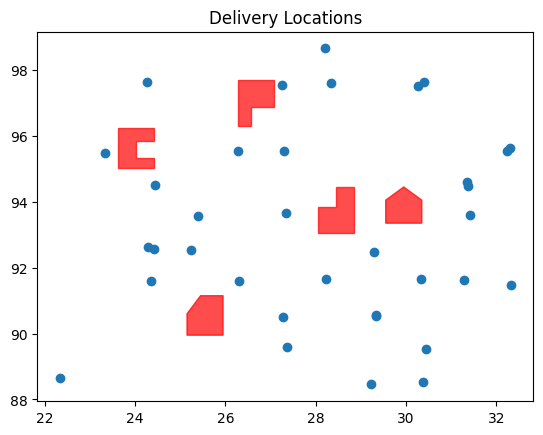

In [318]:
#no of delivery locations and drone capacity
n = random.randint(20,51)
k = 5

# creating the boundary
x = [22.21, 88.45]
y = [32.45, 98.67]
delivery_loc = create_locations(x, y, n)

# obstacles
obstacles = {
    0 : [[28.05, 93.05],[28.85, 93.05],[28.85, 94.45], [28.45, 94.45], [28.45, 93.85],[28.05, 93.85],[28.05, 93.05]],
    1 : [[25.15, 89.95],[25.95, 89.95],[25.95, 91.15], [25.45, 91.15], [25.15, 90.60],[25.15, 89.95]],
    2 : [[26.27, 96.29],[26.57, 96.29],[26.57, 96.89], [27.07, 96.89],[27.07, 97.69], [26.27, 97.69], [26.27, 96.29]],
    3 : [[23.62, 95.04],[24.42, 95.04],[24.42, 95.34], [24.02, 95.34], [24.02, 95.84],[24.42, 95.84],[24.42, 96.24],[23.62, 96.24],[23.62, 96.24]],
    4 : [[29.55, 93.35],[30.35, 93.35],[30.35, 94.05], [29.95, 94.45], [29.55, 94.05], [29.55, 93.35]],
}

delivery_loc = verify_locations(delivery_loc, obstacles)

# Visualize the data
initial_plot(delivery_loc, obstacles)

{0: [[24.4305, 92.5663], [25.4022, 93.5614], [25.2398, 92.5379], [24.2914, 92.6376], [27.3503, 93.6695]], 1: [[31.3796, 94.4845], [31.4229, 93.6079], [32.3023, 95.6353], [31.3505, 94.6157], [32.2256, 95.5461]], 2: [[29.2346, 88.4551], [32.3232, 91.4699], [30.4433, 89.535], [31.2805, 91.6263], [30.381, 88.5187]], 3: [[30.404, 97.649], [28.3389, 97.6108], [28.2129, 98.6531], [27.2646, 97.5515], [30.2738, 97.5122]], 4: [[29.3431, 90.5705], [29.2888, 92.4892], [30.3357, 91.653], [28.2306, 91.6664], [29.3363, 90.5311]], 5: [[24.2544, 97.6493], [27.3086, 95.5484], [23.3343, 95.4833], [26.2871, 95.5403], [24.441, 94.519]], 6: [[22.3384, 88.6394], [24.3573, 91.5883], [27.358, 89.605], [26.307, 91.6068], [27.2755, 90.5036]]}


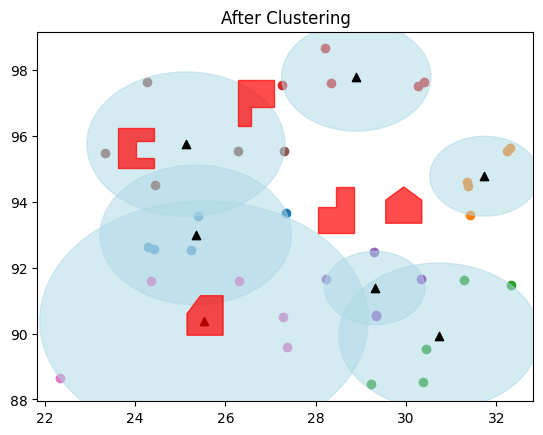

In [319]:
# Cluster the data and get the labels and centroids
centroids, clusters = KMeans(delivery_loc, n, k)

print(clusters)

# Visualize the data
clusters_plot(clusters, centroids, obstacles)

In [320]:
cluster_1 = clusters.copy()
cluster_2 = clusters.copy()
cluster_3 = clusters.copy()
cluster_4 = clusters.copy()
last_cluster = clusters.copy()

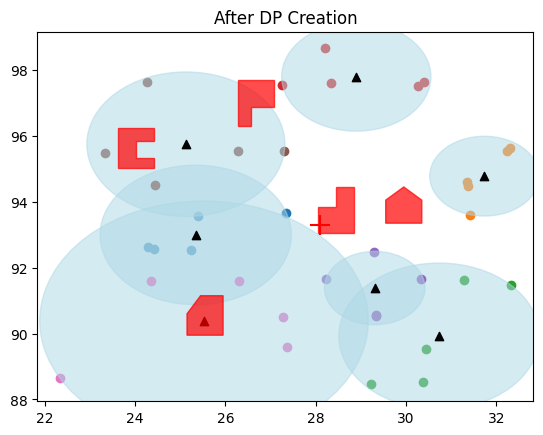

In [321]:
# Calculate DP
DP = calculate_dp(centroids)

# Visualize the data
dp_plot(clusters, centroids, DP, obstacles)

In [322]:
# change dp location if dp on obstacle
DP = varify_dp(DP, obstacles)

In [323]:
def initial_tsp(cluster, dp, method="christofides"):
    
    if method == "christofides":
        path = cluster
        path.append(dp)
        path.insert(0, dp)

        G = nx.Graph()

        for pt in path:
            G.add_node(tuple(pt))

        for i in range(len(path)-1):
            for j in range(i+1,len(path)):
                G.add_edge(tuple(path[i]),tuple(path[j]), weight = calculate_distance(path[i], path[j]))

        path = nx.approximation.traveling_salesman.christofides(G, weight='weight')
    
    elif method == 'brut_force':
        path = list(permutations(cluster))
        cost = []
        # add dp at the start and end
        for i in range(len(path)):
            path[i] = list(path[i])
            path[i].append(dp)
            path[i].insert(0, dp)

            # Calculate distance
            points = path[i]
            sum = 0

            for j in range(len(points)-1):
                sum += calculate_distance(points[j], points[j+1])
            cost.append(sum)

        idx = np.argmin(cost)
        path = path[idx]

    return path

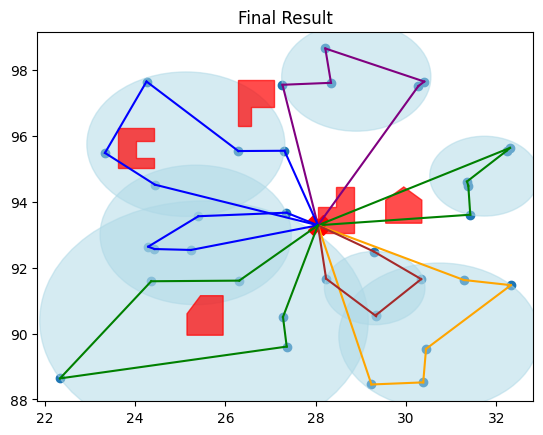

In [324]:
for i in cluster_1:
    cluster_1[i] = initial_tsp(cluster_1[i], DP, method="brut_force")

final_plot(delivery_loc,cluster_1, DP, obstacles)

In [325]:
initial_distance = total_distance(cluster_1)
print("Initial distance, without considering obstacles :",initial_distance)

Initial distance, without considering obstacles : 85.43221876347941


#### Cluster -> Brute Force

In [326]:
# Shortest path calculation in each cluster
for i in cluster_2:
    cluster_2[i] = tsp_brut(cluster_2[i].copy(), DP, obstacles)


Optimal path [(28.05, 93.28678285714285), [25.2398, 92.5379], [24.4305, 92.5663], [24.2914, 92.6376], [25.4022, 93.5614], [27.3503, 93.6695], (28.05, 93.28678285714285)] optimal distance 8.067748934746188
Optimal path [(28.05, 93.28678285714285), [32.3023, 95.6353], [32.2256, 95.5461], [31.3505, 94.6157], [31.3796, 94.4845], [31.4229, 93.6079], (28.05, 93.28678285714285)] optimal distance 11.391783540751634
Optimal path [(28.05, 93.28678285714285), [31.2805, 91.6263], [32.3232, 91.4699], [30.4433, 89.535], [30.381, 88.5187], [29.2346, 88.4551], (28.05, 93.28678285714285)] optimal distance 14.667499868621526
Optimal path [(28.05, 93.28678285714285), [27.2646, 97.5515], [28.3389, 97.6108], [28.2129, 98.6531], [30.404, 97.649], [30.2738, 97.5122], (28.05, 93.28678285714285)] optimal distance 13.90905195425699
Optimal path [(28.05, 93.28678285714285), [29.2888, 92.4892], [30.3357, 91.653], [29.3431, 90.5705], [29.3363, 90.5311], [28.2306, 91.6664], (28.05, 93.28678285714285)] optimal dista

In [327]:
for i in cluster_2:
    print("Path",i,":")
    for j in cluster_2[i]:
        print(j,"->",end=" ")
    print("End")

Path 0 :
(28.05, 93.28678285714285) -> [25.2398, 92.5379] -> [24.4305, 92.5663] -> [24.2914, 92.6376] -> [25.4022, 93.5614] -> [27.3503, 93.6695] -> (28.05, 93.28678285714285) -> End
Path 1 :
(28.05, 93.28678285714285) -> (28.05, 93.85) -> (28.45, 94.45) -> [32.3023, 95.6353] -> [32.2256, 95.5461] -> [31.3505, 94.6157] -> [31.3796, 94.4845] -> [31.4229, 93.6079] -> (30.35, 93.35) -> (28.85, 93.05) -> (28.05, 93.05) -> (28.05, 93.28678285714285) -> End
Path 2 :
(28.05, 93.28678285714285) -> (28.05, 93.05) -> [31.2805, 91.6263] -> [32.3232, 91.4699] -> [30.4433, 89.535] -> [30.381, 88.5187] -> [29.2346, 88.4551] -> (28.05, 93.05) -> (28.05, 93.28678285714285) -> End
Path 3 :
(28.05, 93.28678285714285) -> [27.2646, 97.5515] -> [28.3389, 97.6108] -> [28.2129, 98.6531] -> [30.404, 97.649] -> [30.2738, 97.5122] -> (28.05, 93.85) -> (28.05, 93.28678285714285) -> End
Path 4 :
(28.05, 93.28678285714285) -> (28.05, 93.05) -> [29.2888, 92.4892] -> [30.3357, 91.653] -> [29.3431, 90.5705] -> [29.33

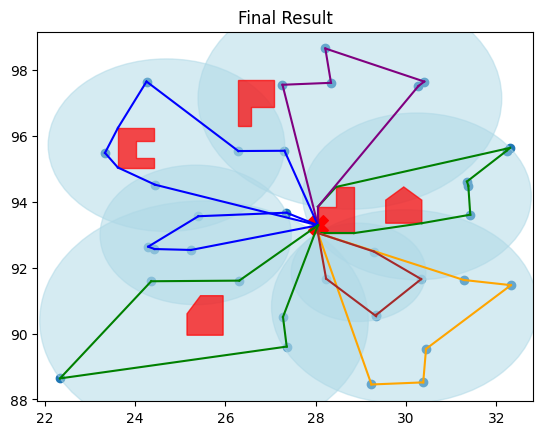

In [328]:
# Final Visualization
final_plot(delivery_loc,cluster_2, DP, obstacles)

#### Cluster_2 -> Crystofieds

In [329]:
# Shortest path calculation in each cluster
for i in cluster_3:
    cluster_3[i] = tsp_crysto(cluster_3[i].copy(), DP, obstacles)

In [330]:
for i in cluster_3:
    print("Path",i,":")
    for j in cluster_3[i]:
        print(j,"->",end=" ")
    print("End")

Path 0 :
(28.05, 93.28678285714285) -> (24.2914, 92.6376) -> (24.4305, 92.5663) -> (25.2398, 92.5379) -> (25.4022, 93.5614) -> (27.3503, 93.6695) -> (28.05, 93.28678285714285) -> End
Path 1 :
(28.05, 93.28678285714285) -> (28.05, 93.85) -> (28.45, 94.45) -> (32.3023, 95.6353) -> (32.2256, 95.5461) -> (31.3505, 94.6157) -> (31.3796, 94.4845) -> (31.4229, 93.6079) -> (30.35, 93.35) -> (28.85, 93.05) -> (28.05, 93.05) -> (28.05, 93.28678285714285) -> End
Path 2 :
(28.05, 93.28678285714285) -> (28.05, 93.05) -> (29.2346, 88.4551) -> (30.381, 88.5187) -> (30.4433, 89.535) -> (31.2805, 91.6263) -> (32.3232, 91.4699) -> (28.05, 93.05) -> (28.05, 93.28678285714285) -> End
Path 3 :
(28.05, 93.28678285714285) -> (28.05, 93.85) -> (30.404, 97.649) -> (30.2738, 97.5122) -> (28.3389, 97.6108) -> (27.2646, 97.5515) -> (28.2129, 98.6531) -> (28.05, 93.85) -> (28.05, 93.28678285714285) -> End
Path 4 :
(28.05, 93.28678285714285) -> (28.05, 93.05) -> (29.2888, 92.4892) -> (28.2306, 91.6664) -> (29.3363,

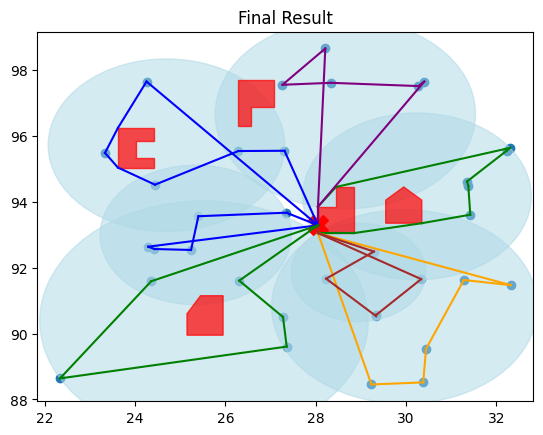

In [331]:
final_plot(delivery_loc,cluster_3, DP, obstacles)

#### Cluster 3 -> Entry Exit method

In [332]:
entry_exit_nodes = []

In [333]:
# centroids, cluster_4 = KMeans(delivery_loc, n, k)

In [334]:
for i, cluster in cluster_4.items():
    cluster_4[i] = minimum_span_tree(cluster.copy(), obstacles)

Optimal path [[24.2914, 92.6376], [24.4305, 92.5663], [25.2398, 92.5379], [25.4022, 93.5614], [27.3503, 93.6695]] optimal distance 3.9535080843737536
Optimal path [[31.4229, 93.6079], [31.3796, 94.4845], [31.3505, 94.6157], [32.2256, 95.5461], [32.3023, 95.6353]] optimal distance 2.4069787089271797
Optimal path [[29.2346, 88.4551], [30.381, 88.5187], [30.4433, 89.535], [31.2805, 91.6263], [32.3232, 91.4699]] optimal distance 5.473386623245598
Optimal path [[30.404, 97.649], [30.2738, 97.5122], [28.3389, 97.6108], [28.2129, 98.6531], [27.2646, 97.5515]] optimal distance 4.6296998650674475
Optimal path [[28.2306, 91.6664], [29.2888, 92.4892], [30.3357, 91.653], [29.3431, 90.5705], [29.3363, 90.5311]] optimal distance 4.188980955750496
Optimal path [[24.2544, 97.6493], [23.3343, 95.4833], [24.441, 94.519], [26.2871, 95.5403], [27.3086, 95.5484]] optimal distance 6.985397182611498
Optimal path [[27.358, 89.605], [27.2755, 90.5036], [26.307, 91.6068], [24.3573, 91.5883], [22.3384, 88.6394]]

In [335]:
for i, cluster in cluster_4.items():
    entry_exit_nodes.append(cluster[0])
    entry_exit_nodes.append(cluster[-1])

In [336]:
entry_exit_nodes

[[24.2914, 92.6376],
 [27.3503, 93.6695],
 [31.4229, 93.6079],
 [32.3023, 95.6353],
 [29.2346, 88.4551],
 [32.3232, 91.4699],
 [30.404, 97.649],
 [27.2646, 97.5515],
 [28.2306, 91.6664],
 [29.3363, 90.5311],
 [24.2544, 97.6493],
 [27.3086, 95.5484],
 [27.358, 89.605],
 [22.3384, 88.6394]]

In [337]:
entry_nodes = [entry_exit_nodes[i] for i in range(0,len(entry_exit_nodes),2)]
exit_nodes = [entry_exit_nodes[i] for i in range(1,len(entry_exit_nodes),2)]

In [338]:
entry_exit_dp = calculate_dp(entry_exit_nodes)

print(entry_exit_dp)

[28.101399999999995, 93.1653857142857]


In [339]:
entry_exit_dp = Optimize_Drone_Position_Euclidean(entry_nodes, exit_nodes, entry_exit_dp)[0]

print(entry_exit_dp)

New Drone: [28.13679822 93.04552755]
[28.13679822 93.04552755]


In [340]:
entry_exit_dp = varify_dp(entry_exit_dp, obstacles)

In [341]:
for cls_id, cluster in cluster_4.items():
    cluster_4[cls_id] = merge_dp(cluster, entry_exit_dp, obstacles)

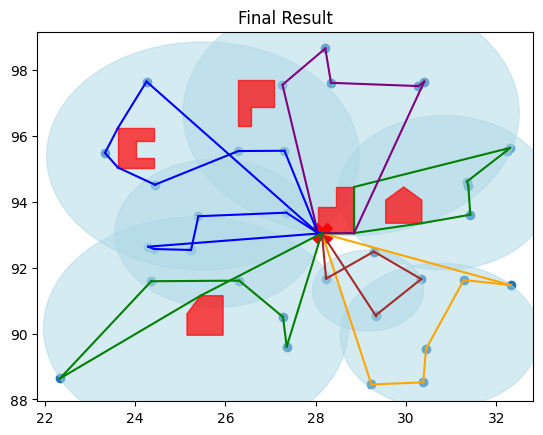

In [342]:
# Final Visualization
final_plot(delivery_loc,cluster_4, entry_exit_dp, obstacles)

In [343]:
entry_exit_distance = total_distance(cluster_4)
print("Distance considering obstacles and entry exit method :",entry_exit_distance)

Distance considering obstacles and entry exit method : 92.67230441218133


## Calculate Total DIstance

*Total distance in manhattan cluster*

In [344]:
new_distance = total_distance(cluster_2)
print("Distance considering obstacles and brute force method :",new_distance)

Distance considering obstacles and brute force method : 86.54380723364785


In [345]:
christofides_distance = total_distance(cluster_3)
print("Distance considering obstacles and christofides method :",christofides_distance)

Distance considering obstacles and christofides method : 91.89769810389151


In [346]:
print(initial_distance)
print(new_distance)
print(christofides_distance)
print(entry_exit_distance)

85.43221876347941
86.54380723364785
91.89769810389151
92.67230441218133


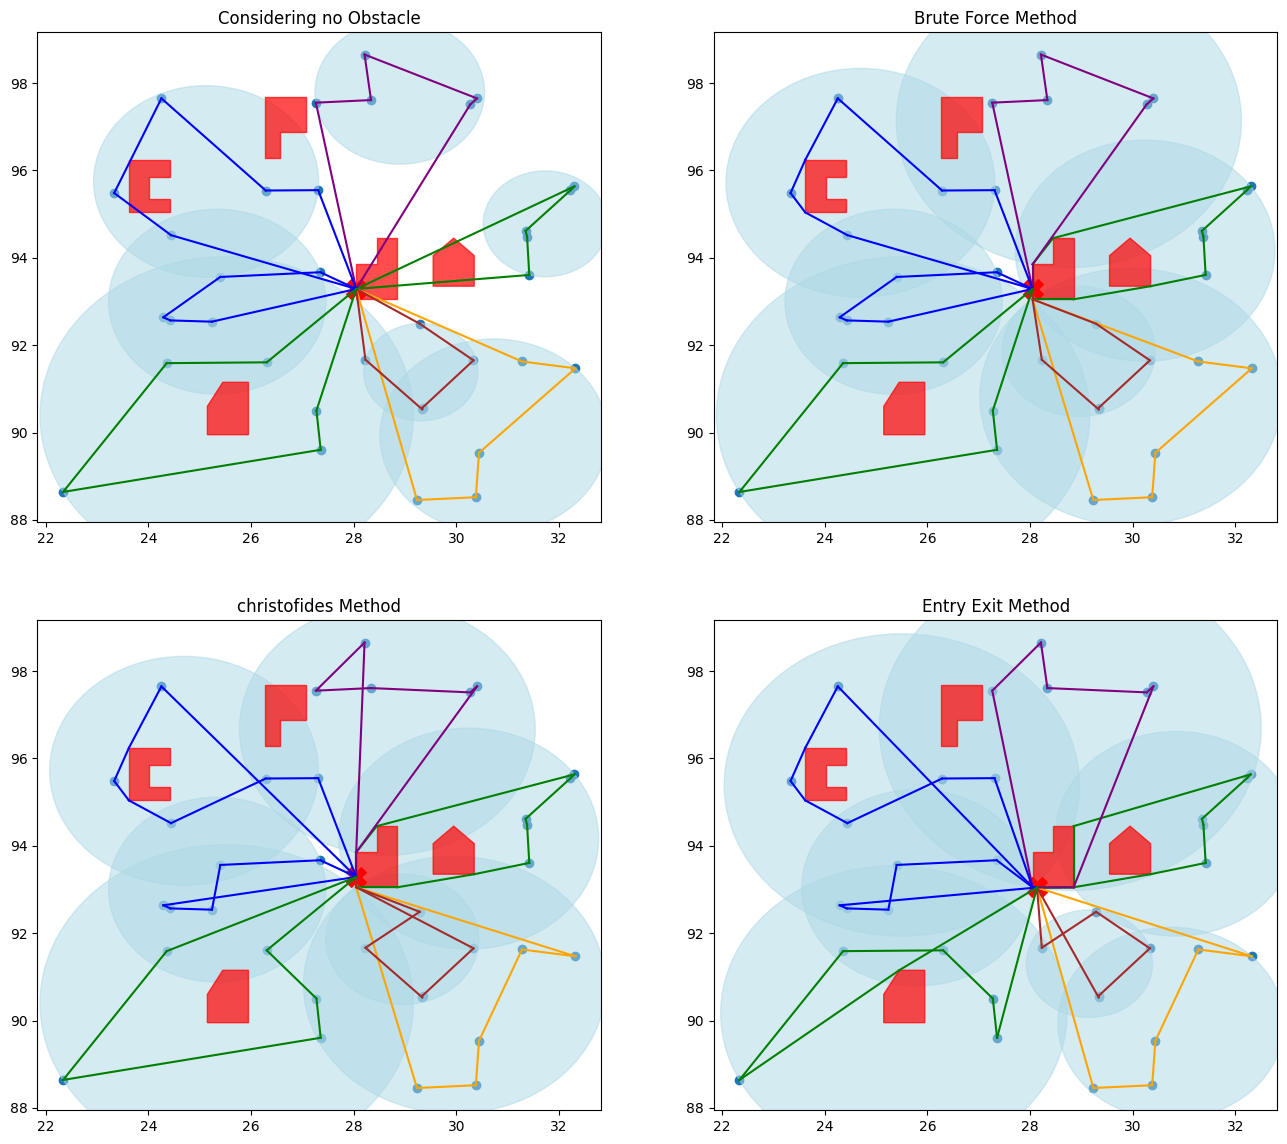

In [347]:
plt.figure(figsize=(16,14))

plt.subplot(2,2,1)
final_plot(delivery_loc,cluster_1, DP, obstacles, title="Considering no Obstacle")
plt.subplot(2,2,2)
final_plot(delivery_loc,cluster_2, DP, obstacles, title = "Brute Force Method")
plt.subplot(2,2,3)
final_plot(delivery_loc,cluster_3, DP, obstacles, title = "christofides Method")
plt.subplot(2,2,4)
final_plot(delivery_loc,cluster_4, entry_exit_dp, obstacles, title = "Entry Exit Method")

plt.show()

## file handling

In [348]:
import pandas as pd

df = pd.read_csv('./drone_performance_on_obstacle_capacity_k.csv')

new_row = {
    'delivary_locations':n,
    'drone_capacity':k,
    'obstacles':len(obstacles),
    'obstacle_free_distance':initial_distance,
    'brut_force_distance':new_distance,
    'christofides_distance':christofides_distance
}

df.loc[len(df)] = new_row

df.tail(5)

,delivary_locations,drone_capacity,obstacles,obstacle_free_distance,brut_force_distance,christofides_distance
49,47,5,5,122.733684,123.750106,127.055679
50,35,5,5,85.023853,85.473064,87.966776
51,47,5,5,114.746291,115.041150,117.350075
52,30,5,5,68.461265,69.318455,71.890604
53,35,5,5,85.432219,86.543807,91.897698


In [349]:
try:
    df.to_csv('./drone_performance_on_obstacle_capacity_k.csv', index=False)
except:
    print("Unknown error occurs")

## Hold